<h1 style="text-align: center">
Deep Learning HW3 </br>
VAE and CVAE
</h1>


### Full Name: Arman Lotfalikhani
### Student ID: 99109166

# Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Data Visualization

In [3]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))  
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize) 

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')  
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

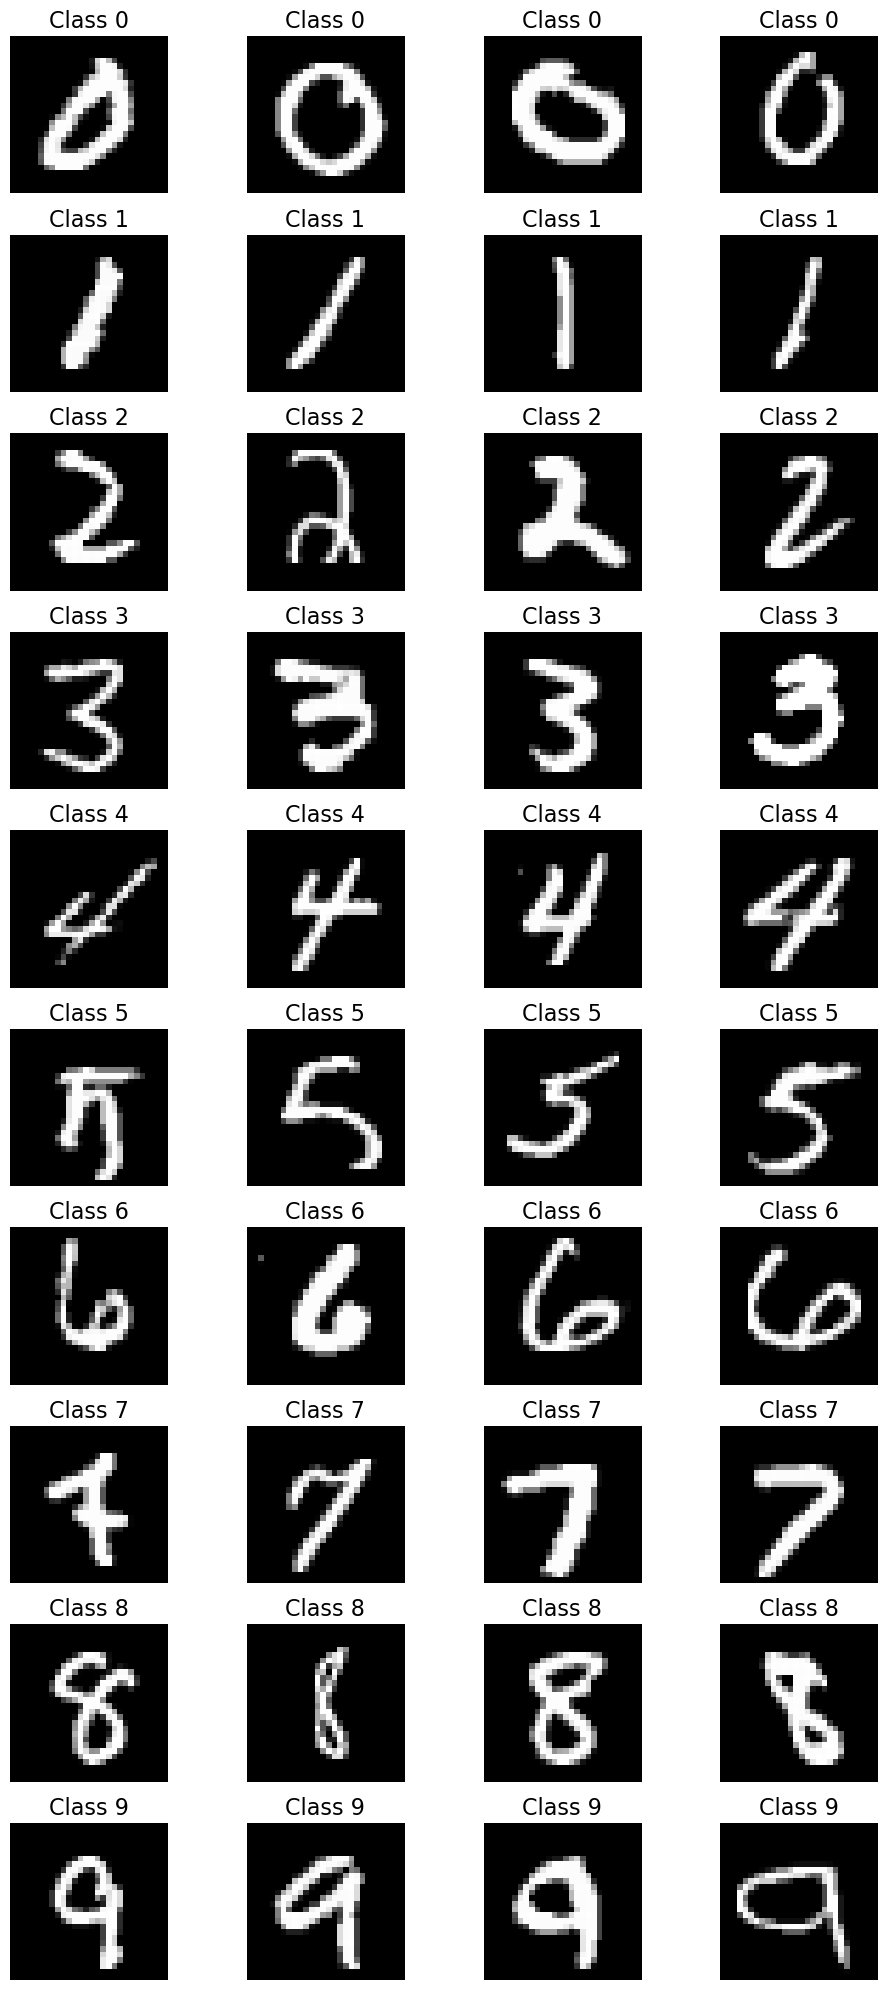

In [4]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP) 

Let's get started!

# 1) VAE --> MLP

In [42]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder and decoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU()
        )
       
        self.fc_mu = nn.Linear(hidden_dim,latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim,latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        sample=torch.randn_like(mu)
        z=mu+torch.exp(0.5 *logvar)*sample
        return z

    def forward(self, x):
        encoded=self.encoder(x)
        mu=self.fc_mu(encoded)
        logvar=self.fc_logvar(encoded)
        z=self.reparameterize(mu,logvar)
        decoded=self.decoder(z)
        return decoded, mu, logvar
    def latent_space_representation(self, x):
        encoded=self.encoder(x)
        mu=self.fc_mu(encoded)
        logvar=self.fc_logvar(encoded)
        z=self.reparameterize(mu,logvar)
        return z

In [13]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    # TODO: Implement the reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon,data, reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence = 1/2*torch.sum(torch.exp(0.5 *logvar)+torch.square(mu)-logvar-1)

    # TODO: Return the total loss as the sum of reconstruction and KL divergence losses
    return reconstruction_loss + kl_divergence

In [7]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3, device='cpu'):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    model=model.to(device)
    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # TODO: Forward process

            # TODO: Flatten the data and recon tensors
            data = torch.flatten(data,start_dim=1).to(device)
            recon, mu, logvar = model(data)

            # TODO: Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()

        avg_loss = total_loss/train_loader.batch_size
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2).to(device)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            #
            best_model ={
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss
            }  # TODO: Save the model

    # TODO: Save the best model to a file
    torch.save(best_model,'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################
VAE-MLP Epoch [1/10], Loss: 179649.6531982422
Sample Images:


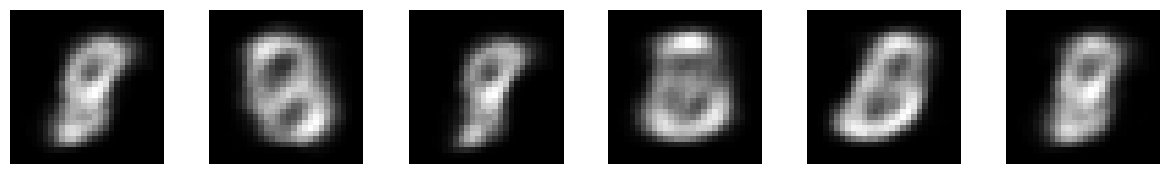


##################################################
VAE-MLP Epoch [2/10], Loss: 155411.92783355713
Sample Images:


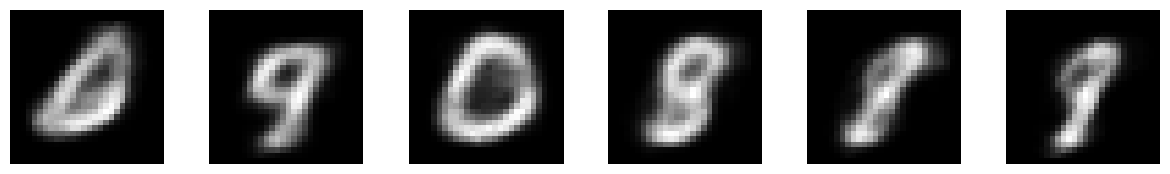


##################################################
VAE-MLP Epoch [3/10], Loss: 149677.97634887695
Sample Images:


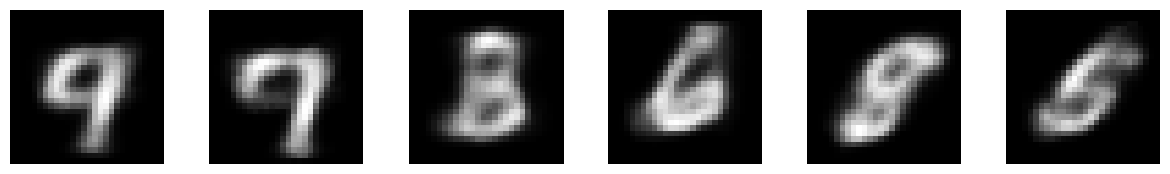


##################################################
VAE-MLP Epoch [4/10], Loss: 146188.04983520508
Sample Images:


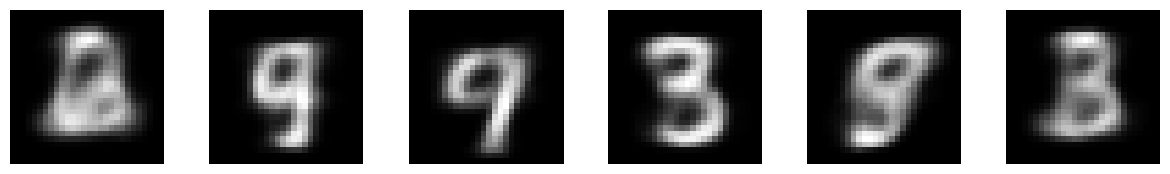


##################################################
VAE-MLP Epoch [5/10], Loss: 144014.39721679688
Sample Images:


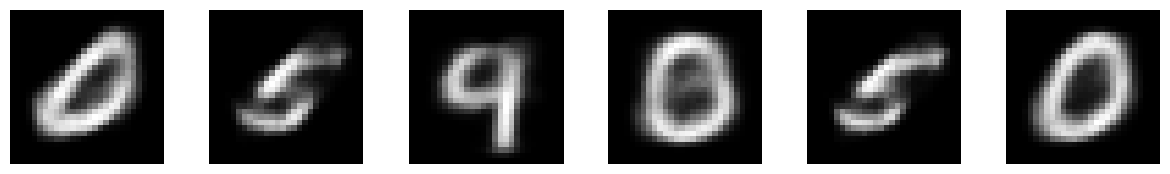


##################################################
VAE-MLP Epoch [6/10], Loss: 142437.4691543579
Sample Images:


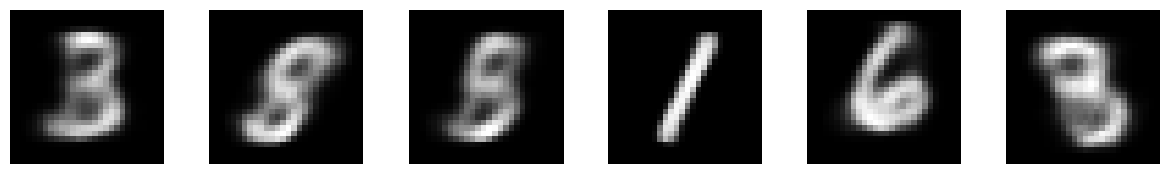


##################################################
VAE-MLP Epoch [7/10], Loss: 141044.94590759277
Sample Images:


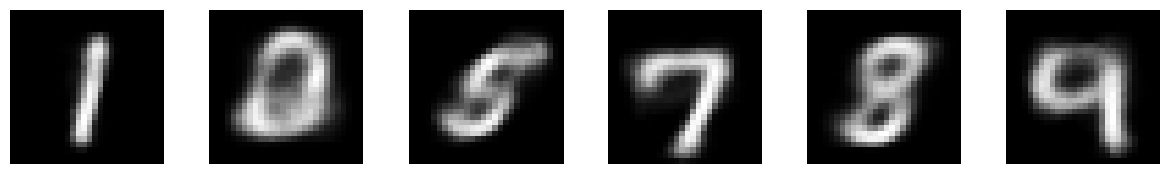


##################################################
VAE-MLP Epoch [8/10], Loss: 139726.09172821045
Sample Images:


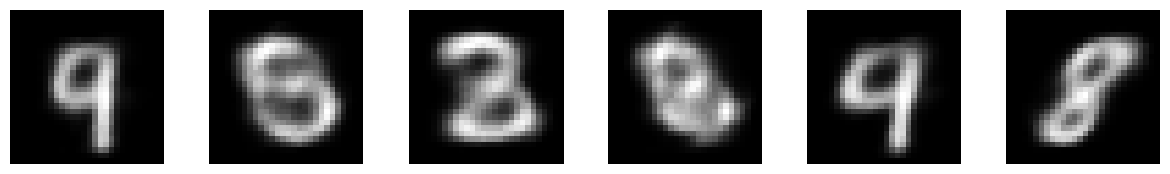


##################################################
VAE-MLP Epoch [9/10], Loss: 138904.51805114746
Sample Images:


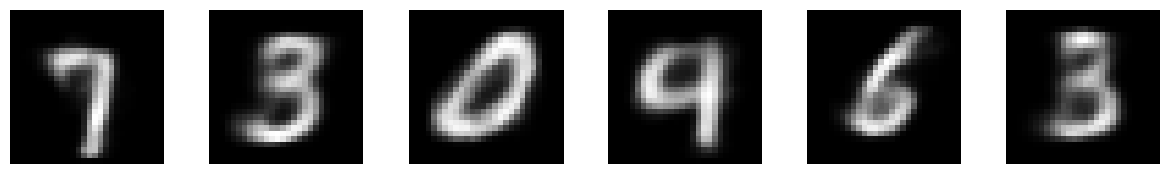


##################################################
VAE-MLP Epoch [10/10], Loss: 138180.13705444336
Sample Images:


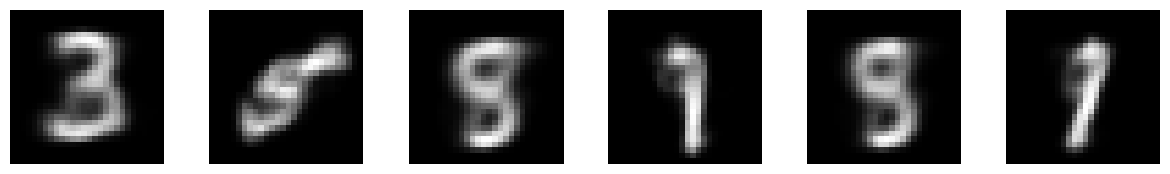

Best model saved as 'best_vae_mlp_model.pth'


In [8]:
# Train VAE-MLP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_mlp = VAE_MLP(784,100,2)
train_vae_mlp(vae_mlp, train_loader, device=device)

# 2) CVAE --> MLP

In [47]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim+num_classes,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_class = nn.Linear(hidden_dim, num_classes)

        # TODO: Define the architecture of the decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim+num_classes,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        sample=torch.randn_like(mu)
        z=mu+torch.exp(0.5 *logvar)*sample
        return z

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # TODO: Concatenate x and y before passing them to the encoder
        x = torch.cat([x,y],dim=1)

        # TODO: Implement the forward pass
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu,logvar)
        class_logits = self.fc_class(hidden)

        reconstructed = self.decoder(torch.cat([z,y],dim=1))

        return reconstructed, mu, logvar, class_logits
    
    def latent_space_representation(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)
        x = torch.cat([x,y],dim=1)
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu,logvar)
        return z

In [39]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # TODO: Flatten the data tensor
    data = torch.flatten(data,start_dim=1)

    # TODO: Implement the reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon,data, reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence = 1/2*torch.sum(torch.exp(0.5 *logvar)+torch.square(mu)-logvar-1)

    # TODO: Implement the cross-entropy loss for class prediction
    ce_loss = F.cross_entropy(class_logits,labels,reduction='mean')

    # TODO: Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    return reconstruction_loss + kl_divergence + ce_loss


__Note: In the following cell, only sending tensors to device (presumably cuda) are added to the pre-written code and no other change has been made.__

In [37]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, device, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None
    model=model.to(device)
    
    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            # One-hot encode the labels
            num_classes=10
            labels_one_hot = F.one_hot(labels,num_classes).to(device)

            data=data.to(device)
            
            # TODO: Forward pass through the model and calculate the loss using cvae_loss
            recon, mu, logvar, class_logits = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels.to(device))

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()
            #optimizer.zero_grad()
            total_loss += loss.item()

        avg_loss = total_loss/train_loader.batch_size
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')
           
        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1).to(device)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss
            } 

    # TODO: Save the best model to a file
    torch.save(best_model,'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################
CVAE-MLP Epoch [1/10], Loss: 169757.8494796753
Sample Images:


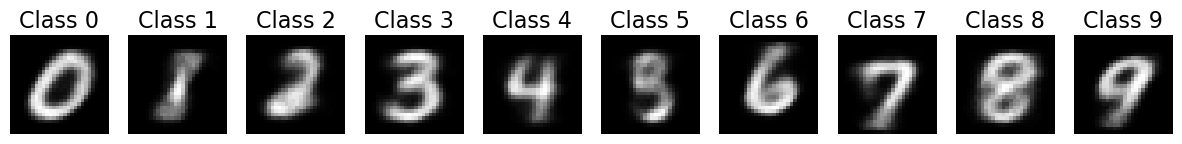


##################################################
CVAE-MLP Epoch [2/10], Loss: 137943.90705108643
Sample Images:


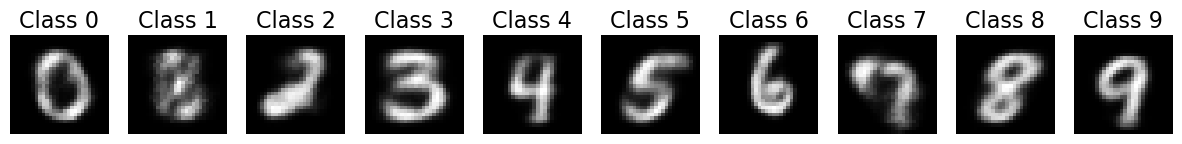


##################################################
CVAE-MLP Epoch [3/10], Loss: 132126.31894683838
Sample Images:


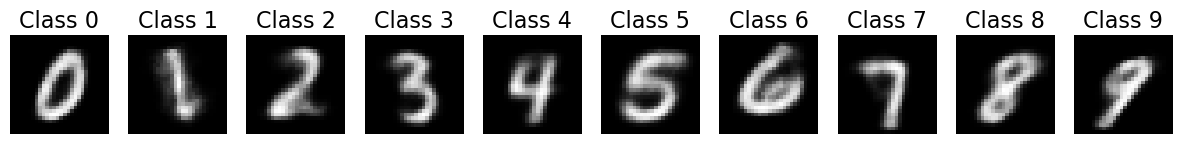


##################################################
CVAE-MLP Epoch [4/10], Loss: 129524.60904693604
Sample Images:


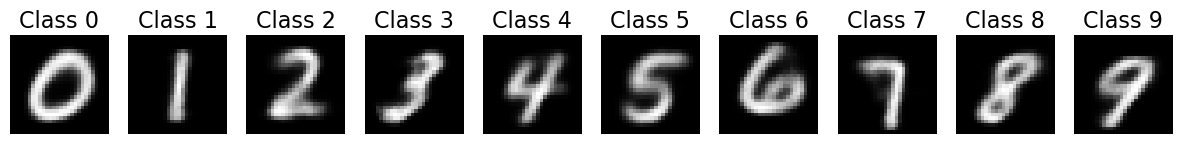


##################################################
CVAE-MLP Epoch [5/10], Loss: 127919.04218292236
Sample Images:


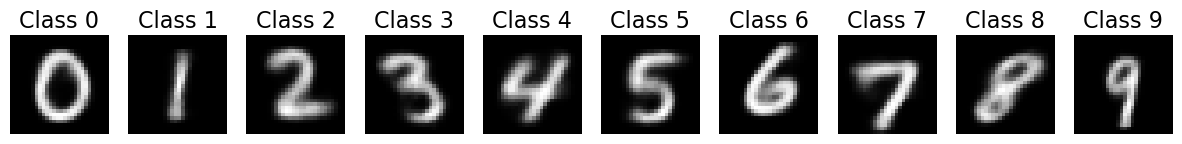


##################################################
CVAE-MLP Epoch [6/10], Loss: 126845.18367004395
Sample Images:


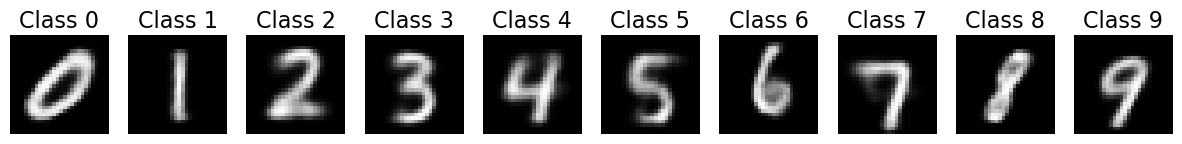


##################################################
CVAE-MLP Epoch [7/10], Loss: 126011.20070648193
Sample Images:


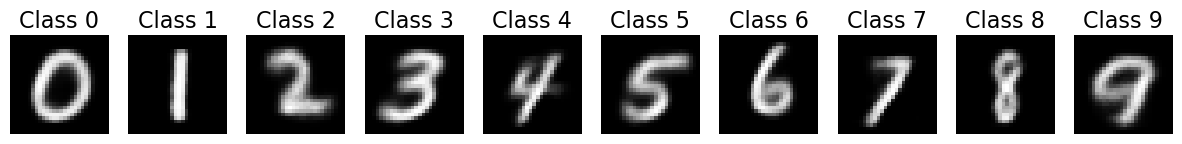


##################################################
CVAE-MLP Epoch [8/10], Loss: 125413.15850067139
Sample Images:


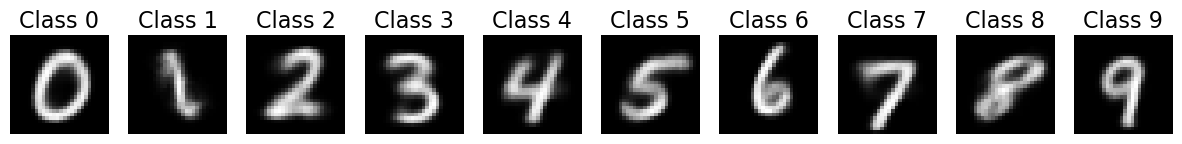


##################################################
CVAE-MLP Epoch [9/10], Loss: 124898.84298706055
Sample Images:


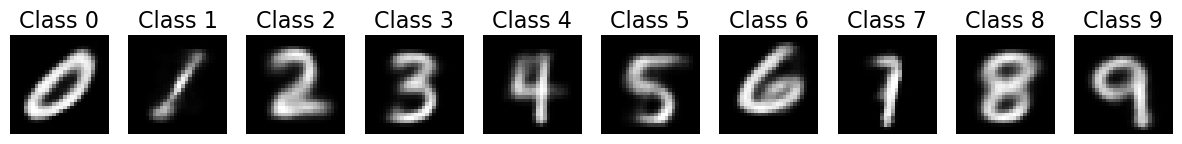


##################################################
CVAE-MLP Epoch [10/10], Loss: 124496.82105255127
Sample Images:


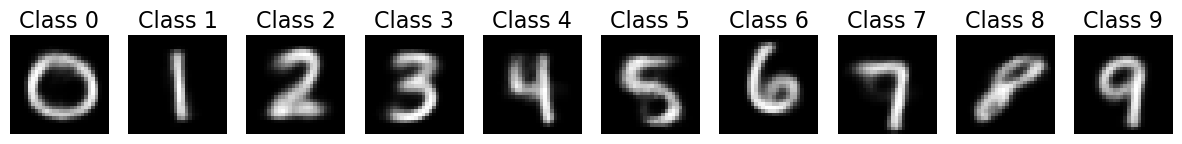

Best model saved as 'best_cvae_mlp_model.pth'


In [40]:
cvae_mlp = CVAE_MLP(784,100,2,10)
train_cvae_mlp(cvae_mlp, train_loader, device=device)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


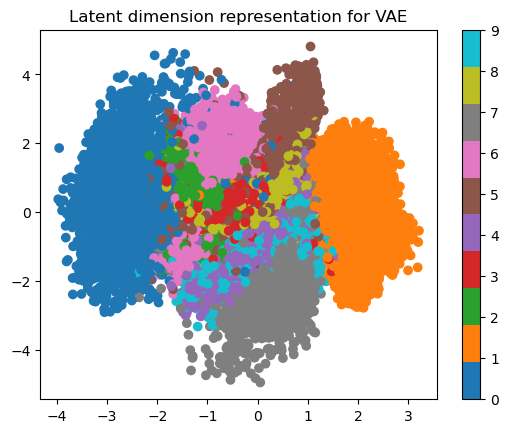

In [46]:
best_vae_mlp=VAE_MLP(784,100,2).to(device)
best_vae_checkpoint=torch.load('best_vae_mlp_model.pth')
best_vae_mlp.load_state_dict(best_vae_checkpoint['model_state_dict'])
with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(train_loader):
        num_classes=10
        data = torch.flatten(data,start_dim=1).to(device)
        latent=best_vae_mlp.latent_space_representation(data).cpu().detach().numpy()
        labels_cpu=labels.detach().numpy()
        plt.scatter(latent[:,0], latent[:, 1], c=labels, cmap='tab10')      
plt.colorbar()
plt.title('Latent dimension representation for VAE')
plt.show()

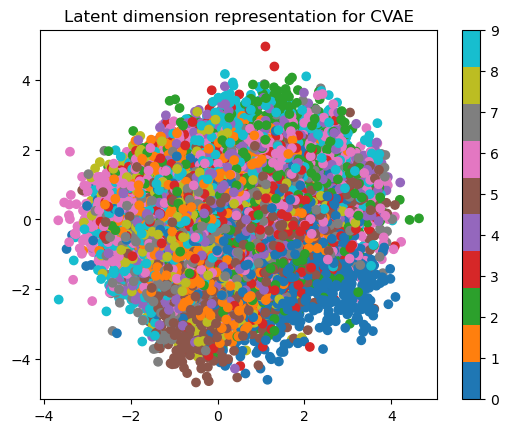

In [51]:
best_cvae_mlp=CVAE_MLP(784,100,2,10).to(device)
best_cvae_checkpoint=torch.load('best_cvae_mlp_model.pth')
best_cvae_mlp.load_state_dict(best_cvae_checkpoint['model_state_dict'])
with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(train_loader):
        num_classes=10
        labels_one_hot = F.one_hot(labels,num_classes).to(device)
        data=data.to(device)
        latent=best_cvae_mlp.latent_space_representation(data,labels_one_hot).cpu().detach().numpy()
        labels_cpu=labels.detach().numpy()
        plt.scatter(latent[:,0], latent[:, 1], c=labels, cmap='tab10')      
plt.colorbar()
plt.title('Latent dimension representation for CVAE')
plt.show()

It is evident that in the CVAE, the datapoints are more intertwined, as the model does not need to separate them via latent space separation and the condition is given to it. This results in greater flexibility and reusing all the latent space effectively. <br>
By contrast, in the VAE, the model needs some partial separation of images with different labels (For example, look at blue dots for 0 images and orange dots for 1 images) so it cannot use all the latent space for each label.